In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('2025_Airbnb_NYC_listings.csv', index_col=0)
df.head(3)

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009-12-11,"New York, NY",I’m an urban planner working for an internatio...,...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010-07-04,"New York, NY",NaN,...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010-07-13,"New York, NY",I am a lawyer and work as an executive at an a...,...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28


In [5]:
# MTA 지하철 데이터 ZIP 파일 URL 리스트

import io
import requests
import zipfile

# 1. GTFS ZIP 다운로드
url = "http://web.mta.info/developers/data/nyct/subway/google_transit.zip"
response = requests.get(url)

# 2. 압축 해제
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("mta_gtfs")

# 3. stops.txt 불러오기 (정류장 데이터)
stops_df = pd.read_csv("mta_gtfs/stops.txt")

# 4. 위도(lat), 경도(lon)만 추출
coords_df = stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]

# CSV 파일로 저장
coords_df.to_csv("subway.csv", index=False)

subway = pd.read_csv('subway.csv')
subway.head(3)

,stop_id,stop_name,stop_lat,stop_lon
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583


In [ ]:
# SHP 파일로 변환
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf_points = gdf_points.to_crs(epsg=32618)
gdf_points.to_file("df_points_32618.shp", encoding="euc-kr")
gdf_estate = gpd.read_file("df_points_32618.shp")

geometry1 = [Point(xy) for xy in zip(subway["stop_lon"], subway["stop_lat"])]
gdf_points1 = gpd.GeoDataFrame(subway, geometry=geometry1, crs="EPSG:4326")
gdf_points1 = gdf_points1.to_crs(epsg=32618)
gdf_points1.to_file("subway_points_32618.shp", encoding="euc-kr")
gdf_subway = gpd.read_file("subway_points_32618.shp")

/var/folders/vr/q6052k192l5b8zc1yrwpz_fw0000gn/T/ipykernel_97218/4195804232.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_points.to_file("df_points_5179.shp", encoding="euc-kr")
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'neighborhood_overview' to 'neighborho'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'host_location' to 'host_locat'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'host_response_time' to 'host_respo

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv
import os

# .env 파일 불러오기
load_dotenv()

# MapBox API 키
MAPBOX_TOKEN = os.environ.get('MAPBOX_API')

# 지하철 데이터 로드 및 좌표 변환
gdf_subway = gpd.read_file("subway_points_32618.shp").to_crs(epsg=4326)
subway_info = list(zip(gdf_subway.geometry.x, gdf_subway.geometry.y, gdf_subway['stop_id']))

# 결과 리스트 초기화
valid_subway_pairs = []

# 거리 계산 
for idx, row in df.iterrows():
    dest_lat = row['latitude']
    dest_lon = row['longitude']
    id = row['id']
    if dest_lat == 0.0 or dest_lon == 0.0:
        continue

    # 가장 가까운 지하철 찾기 (유클리드 거리 기준)
    closest_subway = min(subway_info, key=lambda x: (dest_lat - x[1])**2 + (dest_lon - x[0])**2)
    subway_lon, subway_lat, subway_id = closest_subway

    # Mapbox Directions API 호출
    origin = f"{subway_lon},{subway_lat}"
    destination = f"{dest_lon},{dest_lat}"
    url = f"https://api.mapbox.com/directions/v5/mapbox/walking/{origin};{destination}"
    params = {
        "access_token": MAPBOX_TOKEN,
        "geometries": "geojson",
        "overview": "full"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        if 'routes' in data and data['routes']:
            distance = data['routes'][0]['distance']  # meters
            valid_subway_pairs.append({
                '숙소id': id,
                '지하철id': subway_id,
                '도보거리(m)': round(distance)
            })
    except Exception as e:
        print(f"지하철 경로 오류: {origin} → {destination} / {e}")

# 결과 DataFrame 출력
df_subway = pd.DataFrame(valid_subway_pairs)
display(df_subway)

,숙소id,지하철id,도보거리(m)
0,36121,238,469
1,36647,623,505
2,38663,R31,188
3,38833,A14,137
4,39282,G29,252
...,...,...,...
22303,1366333532374850165,A15,440
22304,1366717321390111215,J29,335
22305,1366721904709517353,632,285
22306,1366722692755341871,D15,281


In [2]:
# df_subway.to_csv('dis_subway.csv', index=False)
dis_subway = pd.read_csv('dis_subway.csv')
dis_subway

,숙소id,지하철id,도보거리(m)
0,36121,238,469
1,36647,623,505
2,38663,R31,188
3,38833,A14,137
4,39282,G29,252
...,...,...,...
22303,1366333532374850165,A15,440
22304,1366717321390111215,J29,335
22305,1366721904709517353,632,285
22306,1366722692755341871,D15,281


In [15]:
# 공항 데이터
import pandas as pd

data = {
    '공항명': ['John F. Kennedy International Airport', 
             'LaGuardia Airport', 
             'Newark Liberty International Airport'],
    '코드': ['JFK', 'LGA', 'EWR'],
    'latitude': [40.645312, 40.777251, 40.688958],
    'longitude': [-73.779616, -73.874129, -74.176941]
}

airport = pd.DataFrame(data)
airport

,공항명,코드,latitude,longitude
0,John F. Kennedy International Airport,JFK,40.645312,-73.779616
1,LaGuardia Airport,LGA,40.777251,-73.874129
2,Newark Liberty International Airport,EWR,40.688958,-74.176941


In [18]:
# SHP 파일로 변환
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf_points = gdf_points.to_crs(epsg=5179)
gdf_points.to_file("df_points_5179.shp", encoding="euc-kr")
gdf_estate = gpd.read_file("df_points_5179.shp")

geometry1 = [Point(xy) for xy in zip(airport["longitude"], airport["latitude"])]
gdf_points1 = gpd.GeoDataFrame(airport, geometry=geometry1, crs="EPSG:4326")
gdf_points1 = gdf_points1.to_crs(epsg=5179)
gdf_points1.to_file("airport_points_5179.shp", encoding="euc-kr")
gdf_airport = gpd.read_file("airport_points_5179.shp")

/var/folders/vr/q6052k192l5b8zc1yrwpz_fw0000gn/T/ipykernel_97218/1684185927.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_points.to_file("df_points_5179.shp", encoding="euc-kr")
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'neighborhood_overview' to 'neighborho'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'host_location' to 'host_locat'
  ogr_write(
/Users/t2024-m0247/Desktop/심화프로젝트/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'host_response_time' to 'host_respo

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv
import os

# .env 파일 불러오기
load_dotenv()

# Mapbox API 키
MAPBOX_TOKEN = os.environ.get('MAPBOX_API')

# 공항 데이터 로드 및 좌표 변환
gdf_airport = gpd.read_file("airport_points_5179.shp").to_crs(epsg=4326)
airport_info = list(zip(gdf_airport.geometry.x, gdf_airport.geometry.y, gdf_airport['코드']))

# 결과 리스트 초기화
valid_airport_pairs = []

# 거리 계산 
for idx, row in df.iterrows():
    dest_lat = row['latitude']
    dest_lon = row['longitude']
    id = row['id']
    if dest_lat == 0.0 or dest_lon == 0.0:
        continue

    # 가장 가까운 공항 찾기 (유클리드 거리 기준)
    closest_airport = min(airport_info, key=lambda x: (dest_lat - x[1])**2 + (dest_lon - x[0])**2)
    airport_lon, airport_lat, airport_id = closest_airport

    # Mapbox Directions API 호출
    origin = f"{airport_lon},{airport_lat}"
    destination = f"{dest_lon},{dest_lat}"
    url = f"https://api.mapbox.com/directions/v5/mapbox/driving/{origin};{destination}"
    params = {
        "access_token": MAPBOX_TOKEN,
        "geometries": "geojson",
        "overview": "full"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        if 'routes' in data and data['routes']:
            distance = data['routes'][0]['distance']  # meters
            valid_airport_pairs.append({
                '숙소id': id,
                '공항': airport_id,
                '자동차거리(m)': round(distance)
            })
    except Exception as e:
        print(f"공항 경로 오류: {origin} → {destination} / {e}")

# 결과 DataFrame 출력
df_airport = pd.DataFrame(valid_airport_pairs)
display(df_airport)

,숙소id,공항,자동차거리(m)
0,36121,LGA,16410
1,36647,LGA,11285
2,38663,LGA,16893
3,38833,LGA,11367
4,39282,LGA,11350
...,...,...,...
22291,1366333532374850165,LGA,11608
22292,1366717321390111215,LGA,19518
22293,1366721904709517353,LGA,13191
22294,1366722692755341871,LGA,14204


In [3]:
# df_airport.to_csv('dis_airport.csv', index=False)
dis_airport = pd.read_csv('dis_airport.csv')
dis_airport

,숙소id,공항,자동차거리(m)
0,36121,LGA,16410
1,36647,LGA,11285
2,38663,LGA,16893
3,38833,LGA,11367
4,39282,LGA,11350
...,...,...,...
22291,1366333532374850165,LGA,11608
22292,1366717321390111215,LGA,19518
22293,1366721904709517353,LGA,13191
22294,1366722692755341871,LGA,14204


In [4]:
import pandas as pd
dis_bus = pd.read_csv('airbnb_bus_stop_walking_distance.csv')
dis_bus

,id,bus_stop,w_distance
0,3.612100e+04,WASHINGTON AV/STERLING PL,433
1,3.664700e+04,2 AV/E 111 ST,168
2,3.866300e+04,DEAN ST/3 AV,147
3,3.883300e+04,SAINT NICHOLAS AV/W 137 ST,78
4,3.928200e+04,GRAND ST/UNION AV,51
...,...,...,...
22303,1.366334e+18,CONVENT AV/W 129 ST,91
22304,1.366717e+18,HALSEY ST/HOWARD AV,115
22305,1.366722e+18,3 AV/E 33 ST,108
22306,1.366723e+18,6 AV/W 45 ST,93


In [5]:
dis_subway = dis_subway.rename(columns={'도보거리(m)':'walk_subway(m)', '숙소id':'id'}).drop('지하철id', axis=1)
dis_bus = dis_bus.rename(columns={'w_distance':'walk_bus(m)'}).drop('bus_stop', axis=1)
dis_airport = dis_airport.rename(columns={'자동차거리(m)':'car_airport(m)', '숙소id':'id'}).drop('공항', axis=1)

In [6]:
df_merged = pd.merge(dis_subway, dis_bus, on='id', how='left')
new_df = pd.merge(df_merged, dis_airport, on='id', how='left')

In [32]:
pd.set_option('display.float_format', '{:.0f}'.format) 

In [7]:
new_df.to_csv('mapbox.csv', index=False)
new_df = pd.read_csv('mapbox.csv')
new_df

,id,walk_subway(m),walk_bus(m),car_airport(m)
0,36121,469,433.0,16410.0
1,36647,505,168.0,11285.0
2,38663,188,147.0,16893.0
3,38833,137,78.0,11367.0
4,39282,252,51.0,11350.0
...,...,...,...,...
22303,1366333532374850165,440,91.0,11608.0
22304,1366717321390111215,335,115.0,19518.0
22305,1366721904709517353,285,108.0,13191.0
22306,1366722692755341871,281,93.0,14204.0


In [10]:
new_df[['walk_subway(m)', 'walk_bus(m)', 'car_airport(m)']].head(5)

,walk_subway(m),walk_bus(m),car_airport(m)
0,469,433.0,16410.0
1,505,168.0,11285.0
2,188,147.0,16893.0
3,137,78.0,11367.0
4,252,51.0,11350.0


In [36]:
# 버스정류장, 지하철, 공항 거리 컬럼 추가
distance = pd.read_csv('mapbox.csv')
new_df = pd.merge(df, distance, on='id', how='left')

In [37]:
new_df.isnull().sum()

id                                                 0
source                                             0
name                                               0
description                                      405
neighborhood_overview                          10046
                                               ...  
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               6798
walk_subway(m)                                     0
walk_bus(m)                                     2208
car_airport(m)                                    12
Length: 75, dtype: int64

In [7]:
# 가격 데이터 범주형 -> 수치형 전환
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype('float')

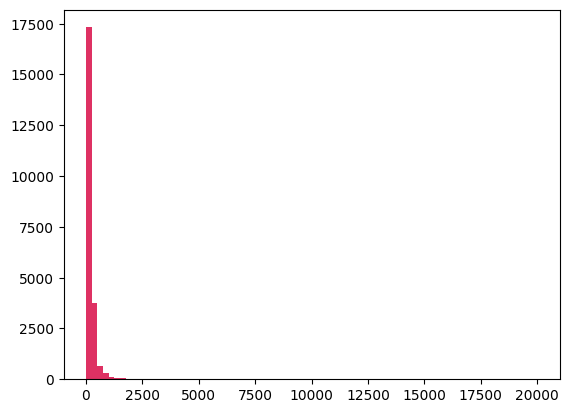

In [12]:
import matplotlib.pyplot as plt
plt.hist(df['price'], bins=80, color='#DE3163')
plt.show()

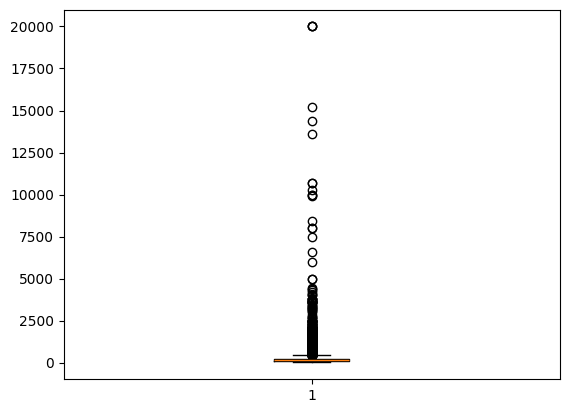

In [9]:
plt.boxplot(df['price'])
plt.show()

In [13]:
# 가격 이상치 제거
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
under_bound = Q1 - 1.5 * IQR
df = df[(df['price'] >= 37) & (df['price'] <= upper_bound)]

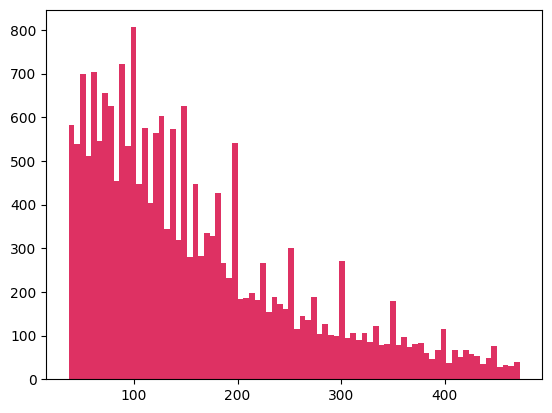

In [14]:
import matplotlib.pyplot as plt
plt.hist(df['price'], bins=80, color='#DE3163')
plt.show()

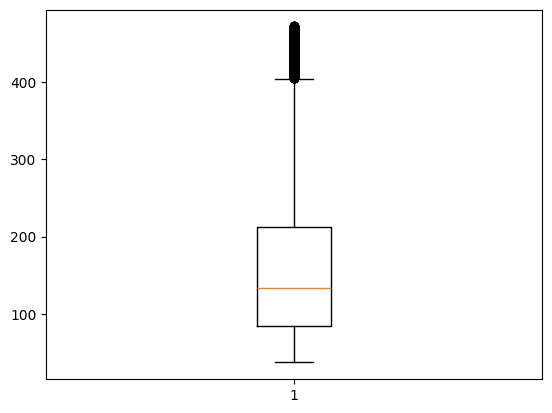

In [15]:
plt.boxplot(df['price'])
plt.show()